<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Import libraries](#2)
1. [Download data](#3)
1. [EDA](#4)
1. [Data Cleaning](#5)

1. [Bag of Words Counts](#7)
1. [TF IDF](#8)
1. [GloVe](#9)
1. [BERT using TFHub](#10)
   - [Submission by BERT](#10.1)
1. [Clustering](#11)

## 2. Import libraries <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Bidirectional, TimeDistributed, Flatten
from keras.initializers import Constant
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

Using TensorFlow backend.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/realornot-2020/test_cleaned.csv
/kaggle/input/realornot-2020/submission.csv
/kaggle/input/realornot-2020/train_cleaned.csv


## 3. Download data <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

In [3]:
# this data has already been cleaned locally
tweet= pd.read_csv('../input/realornot-2020/train_cleaned.csv')
test= pd.read_csv('../input/realornot-2020/test_cleaned.csv')
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [4]:
# # From https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data - 
# # author of this kernel read tweets in training data and figure out that some of them have errors:
# ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
# tweet.loc[tweet['id'].isin(ids_with_target_error),'target'] = 0
# tweet[tweet['id'].isin(ids_with_target_error)]

In [5]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 7 columns in train
There are 3263 rows and 5 columns in train


In [6]:
tweet.head(10)

,id,keyword,location,text,target,text_cleaned,target_relabeled
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,# Rocky Fire Update = > California Hwy . ...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,# flood # disaster Heavy rain causes flash f...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,I am on top of the hill and I can see a fire i...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,There is an emergency evacuation happening now...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,I am afraid that the tornado is coming to our ...,1


## 4. EDA <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

Thanks to:
* https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
* https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
* https://www.kaggle.com/itratrahman/nlp-tutorial-using-python

### Class distribution

Before we begin with anything else, let's check the class distribution.

In [7]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]
print(Real_len)
print(Not_len)

3271
4342


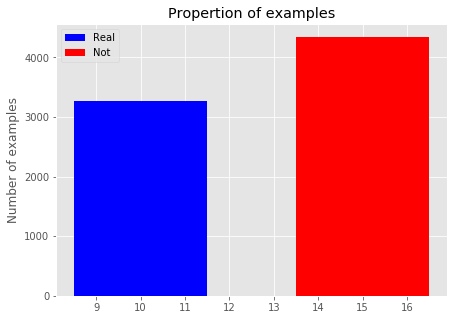

In [8]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

### Number of characters in tweets

In [9]:
tweet['length'] = tweet['text'].apply(lambda x: len(x))

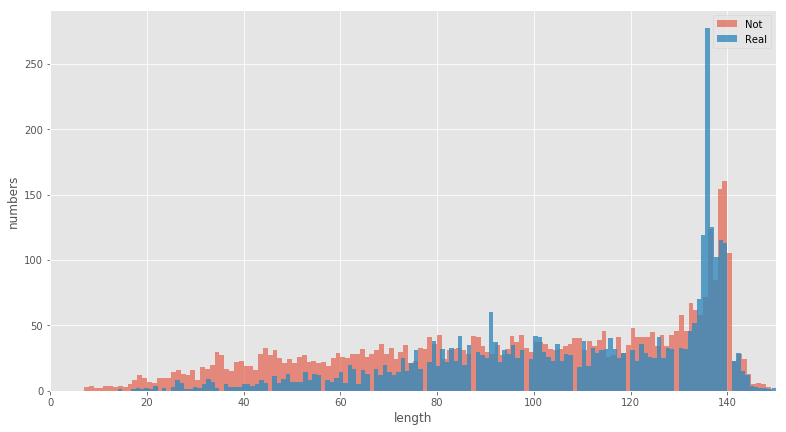

In [10]:
plt.rcParams['figure.figsize'] = (13, 7)
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=150, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=150, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
# plt.grid()
plt.show()

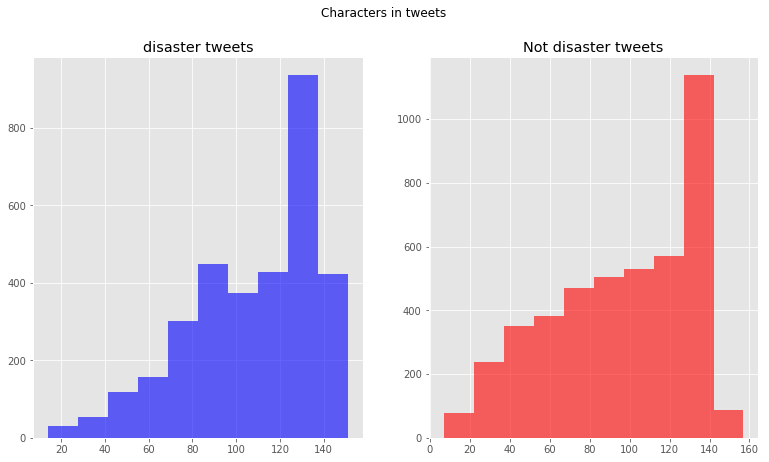

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,7))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue',alpha = 0.6)
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red',alpha = 0.6)
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

### Number of words in a tweet

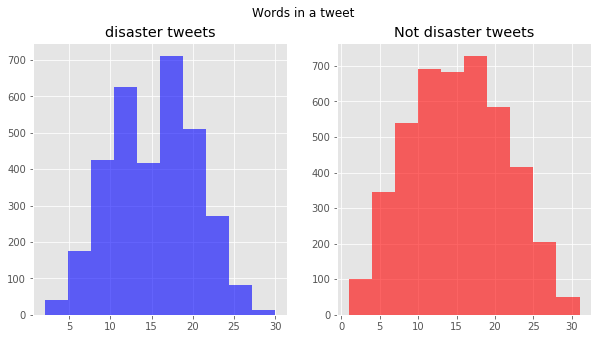

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue', alpha=0.6)
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red', alpha=0.6)
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


###  Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

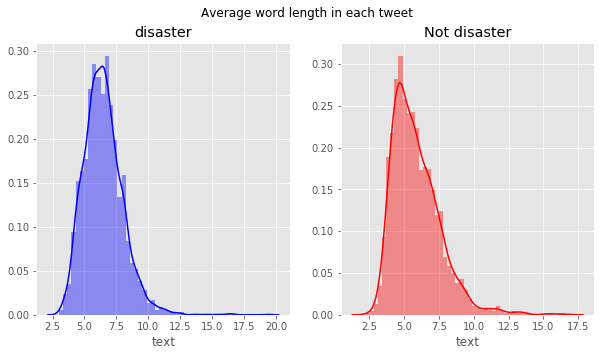

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [14]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [15]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in tweets

First we  will analyze tweets with class 0.

In [16]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [17]:
# displaying the stopwords
np.array(stop)

array({'hers', 'the', 'shouldn', 'didn', 't', 'been', 'through', 'me', 'ain', 'more', "won't", 'couldn', 'between', 'will', 'doesn', 'they', 'that', 'above', 'ours', 'have', 'which', 'be', "mustn't", 'other', 'once', "wasn't", 'up', 'wasn', 'but', 'needn', 'below', 'before', 'further', 'himself', 'all', 'being', 'from', 'during', 'do', "aren't", 'too', 'he', 'myself', 'a', 'll', 'herself', 'm', 're', 'aren', "doesn't", 'had', 'it', "you'll", 'under', 'any', 'y', 'o', 'i', 'who', 'same', 'wouldn', 'again', 'here', 'them', 'our', 'its', "hasn't", 'were', 'how', 'while', 'mightn', 'hasn', 'isn', 'with', 'until', 'and', 'such', "wouldn't", 'not', 'than', 'because', 'out', 'am', 'ourselves', 'when', 'hadn', 'most', 'her', 'you', "didn't", 'does', 'yourself', 'off', 'doing', 'nor', 'weren', "shan't", 'themselves', 'into', 'we', 'your', 'this', "shouldn't", "she's", 'an', 'has', 'she', 'about', "it's", "haven't", 'did', 'on', 'having', 'of', 'to', "that'll", 'few', 'these', 'some', 'at', "you

<BarContainer object of 10 artists>

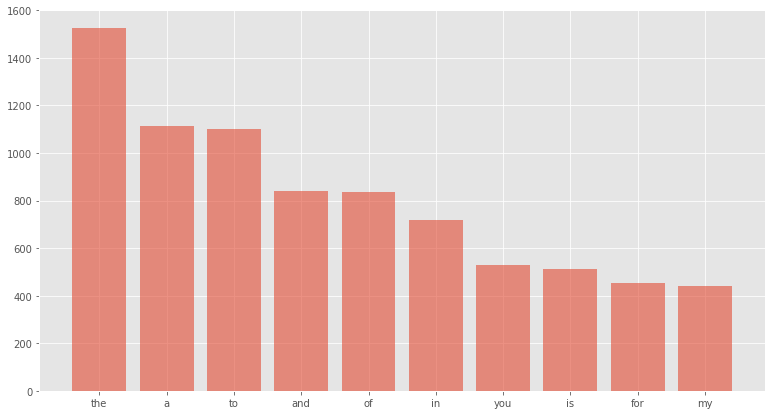

In [18]:
plt.rcParams['figure.figsize'] = (13, 7)
x,y=zip(*top)
plt.bar(x,y, alpha = 0.6)

Now,we will analyze tweets with class 1.

<BarContainer object of 10 artists>

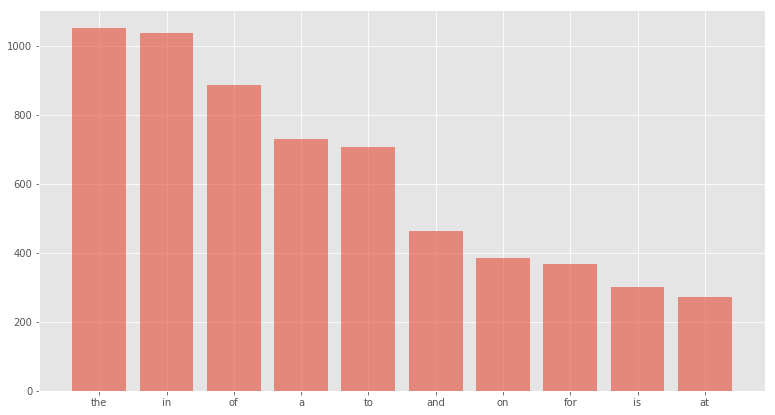

In [19]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (13, 7)
x,y=zip(*top)
plt.bar(x,y, alpha=0.6)

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

### Analyzing punctuations

First let's check tweets indicating real disaster.

<BarContainer object of 18 artists>

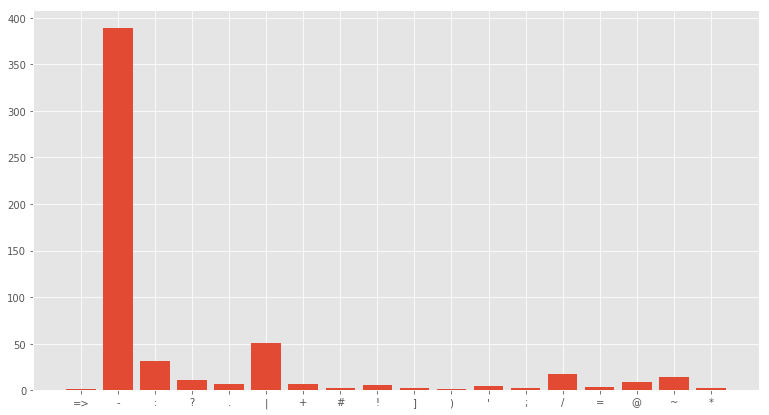

In [20]:
plt.figure(figsize=(13,7))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now,we will move on to class 0.

<BarContainer object of 20 artists>

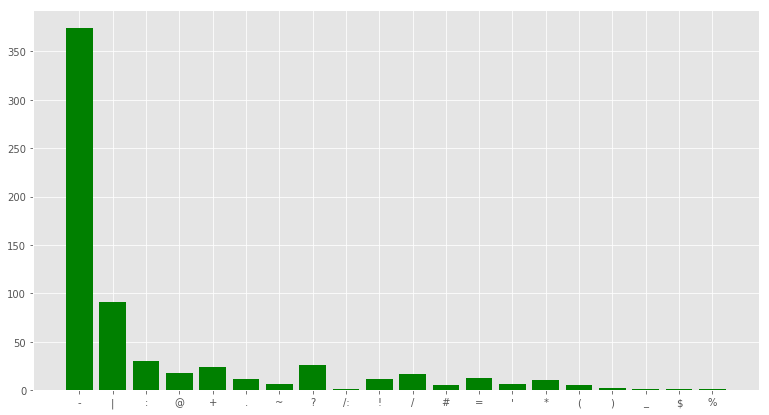

In [21]:
plt.figure(figsize=(13,7))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words

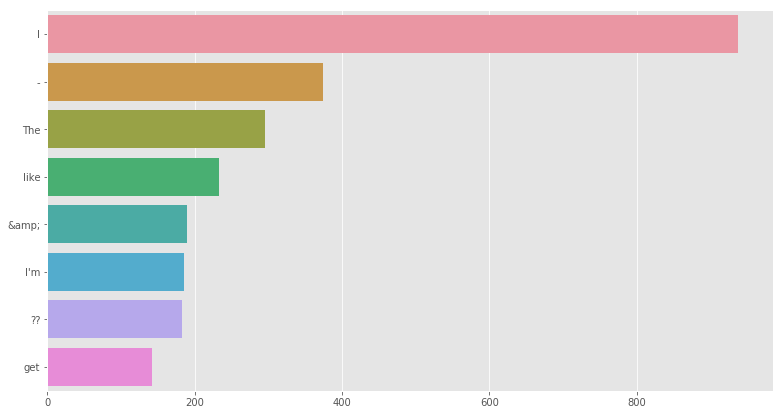

In [22]:
plt.figure(figsize=(13,7))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

Lot of cleaning needed !

### N-gram analysis

we will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets.

In [23]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

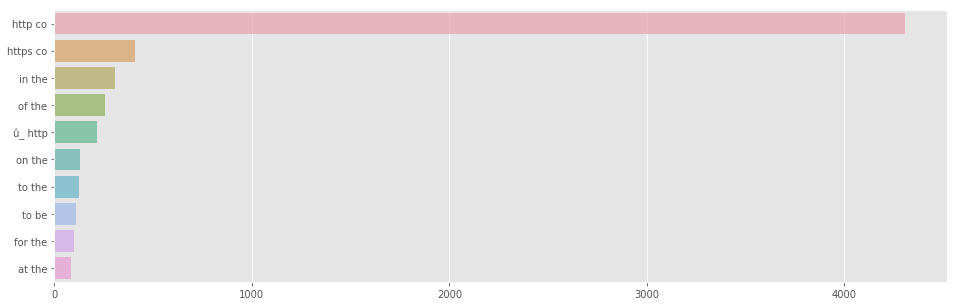

In [24]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x, alpha=0.6)

## 5. Data Cleaning <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [25]:
df=pd.concat([tweet,test])
df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 8)

In [26]:
df.head()

,id,keyword,length,location,target,target_relabeled,text,text_cleaned
0,1,NaN,69.0,NaN,1.0,1.0,Our Deeds are the Reason of this #earthquake M...,Our Deeds are the Reason of this # earthquake...
1,4,NaN,38.0,NaN,1.0,1.0,Forest fire near La Ronge Sask. Canada,Forest fire near La Ronge Sask . Canada
2,5,NaN,133.0,NaN,1.0,1.0,All residents asked to 'shelter in place' are ...,All residents asked to ' shelter in place ' ...
3,6,NaN,65.0,NaN,1.0,1.0,"13,000 people receive #wildfires evacuation or...","13,000 people receive # wildfires evacuation ..."
4,7,NaN,88.0,NaN,1.0,1.0,Just got sent this photo from Ruby #Alaska as ...,Just got sent this photo from Ruby # Alaska a...


### Removing urls

In [ ]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

### Removing HTML tags

In [ ]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))

In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Removing Emojis

In [ ]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### REmove non ASCII and links

In [ ]:
def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""
    
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet

### Removing punctuations

In [ ]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [ ]:
df['text']=df['text'].apply(lambda x : x.lower())

In [ ]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

### Stemming & Lemmatizing

In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

#create an object of class PorterStemmer
porter = PorterStemmer()
lancaster=LancasterStemmer()

# Some examples from datacamps: https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
#proide a word to be stemmed
print("Porter Stemmer")
print(porter.stem("cats"))
print(porter.stem("trouble"))
print(porter.stem("troubling"))
print(porter.stem("troubled"))
print("\n")
print("Lancaster Stemmer")
print(lancaster.stem("cats"))
print(lancaster.stem("trouble"))

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

sentence = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
punctuations="?:!.,;"
sentence_words = nltk.word_tokenize(sentence)
for word in sentence_words:
    if word in punctuations:
        sentence_words.remove(word)

sentence_words
print("{0:20}{1:20}".format("Word","Lemma"))
for word in sentence_words:
    print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word)))

In [ ]:
def lemmatization(text):
    tmp = text.split()
    tmp = [wordnet_lemmatizer.lemmatize(i, "a") for i in tmp]
    return " ".join(tmp)

example="He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
print(lemmatization(example.lower()))

In [ ]:
df['text'] = df['text'].apply(lambda x : lemmatization(x))

## 7. Bag of Words Counts <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

Thanks to https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [27]:
df.dropna(subset=["target"], inplace=True)

In [28]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text_cleaned"].tolist()
list_labels = df["target_relabeled"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings

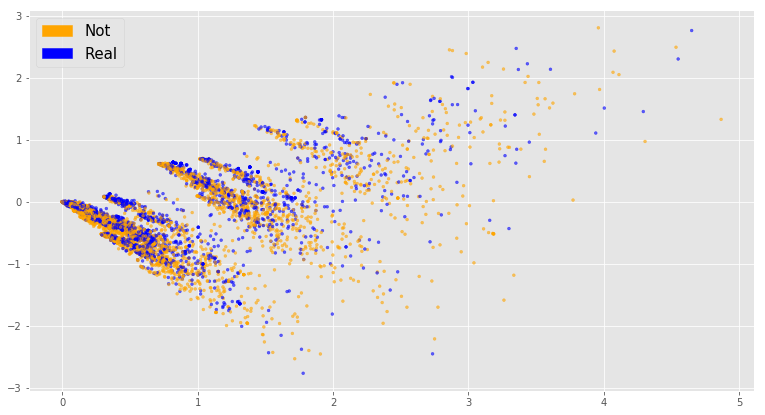

In [29]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.6, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

fig = plt.figure(figsize=(13, 7))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

## 8. TF IDF <a class="anchor" id="8"></a>

[Back to Table of Contents](#0.1)

In [31]:
columns = df.columns
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing (%)': percent_missing})
missing_value_df.sort_values('percent_missing (%)', inplace=True, ascending=False)
missing_value_df.head(50)

,column_name,percent_missing (%)
location,location,33.272035
keyword,keyword,0.801261
id,id,0.000000
length,length,0.000000
target,target,0.000000
target_relabeled,target_relabeled,0.000000
text,text,0.000000
text_cleaned,text_cleaned,0.000000


In [33]:
def tfidf(data):
    # tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(2, 2), stop_words='english')

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

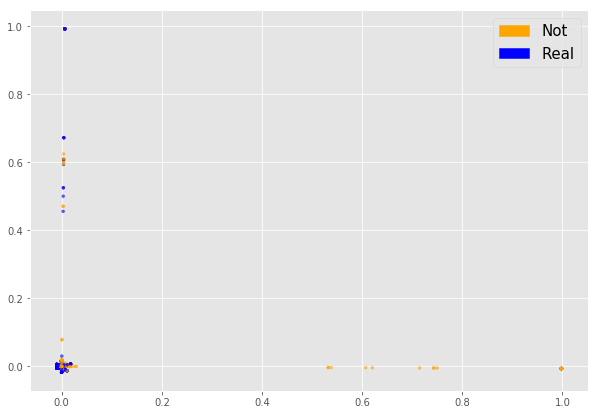

In [34]:
fig = plt.figure(figsize=(10, 7))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [35]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(2, 2), stop_words='english')
# list_corpus = df["text"]#.tolist()
features = X_train_tfidf.toarray()
labels = y_train#.tolist()
features.shape

(6090, 1725)

> eaach of 6090 headlines is represented by 1725 features, representing the tf-idf score for different unigrams and bigrams.

In [37]:
# category_id_df = df[['label', 'target']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)

# for label, category_id in sorted(category_to_id.items()):
#     print(label, category_id)
category_to_id = {"fake":0, "real":1}

In [ ]:
# from sklearn.feature_selection import chi2

# #  find the terms that are the most correlated with each of the categories:
# N = 2
# for label, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

#     print("# '{}':".format(label))
#     print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [38]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.datasets import make_classification
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.calibration import CalibratedClassifierCV
import string
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.stem import SnowballStemmer,PorterStemmer
from nltk.corpus import stopwords,state_union
import os
import random
from statistics import mode
from io import StringIO
import re
import pickle
import sys, getopt

In [39]:
%%time
models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(),
    SVC()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

CPU times: user 6min 45s, sys: 5.58 s, total: 6min 50s
Wall time: 6min 44s


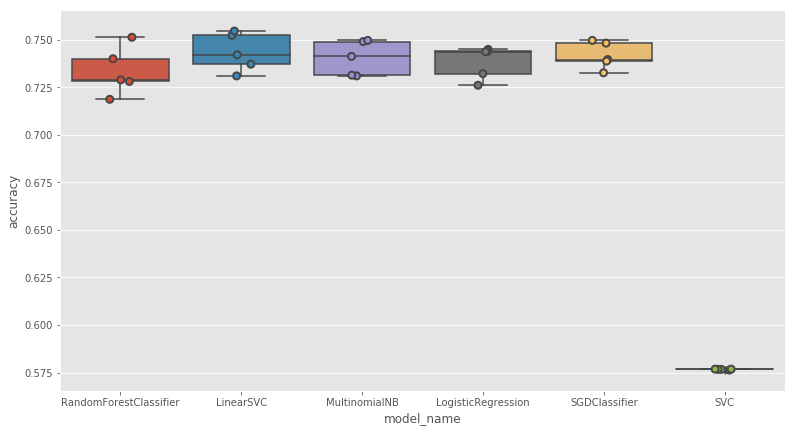

In [40]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=7, jitter=True, edgecolor="gray", linewidth=2)

sns.set(rc={'figure.figsize':(12, 12)})
plt.show()

In [41]:
cv_df.groupby('model_name').accuracy.mean().sort_values(ascending=False)

model_name
LinearSVC                 0.743349
SGDClassifier             0.741707
MultinomialNB             0.740393
LogisticRegression        0.738096
RandomForestClassifier    0.733333
SVC                       0.576683
Name: accuracy, dtype: float64

Testing accuracy 0.7209455022980958
Testing F1 score: 0.6987924230248163

Clasification report:
               precision    recall  f1-score   support

         0.0       0.68      0.94      0.79       858
         1.0       0.85      0.44      0.58       665

    accuracy                           0.72      1523
   macro avg       0.77      0.69      0.69      1523
weighted avg       0.76      0.72      0.70      1523


Confusion Matrix is very confusing


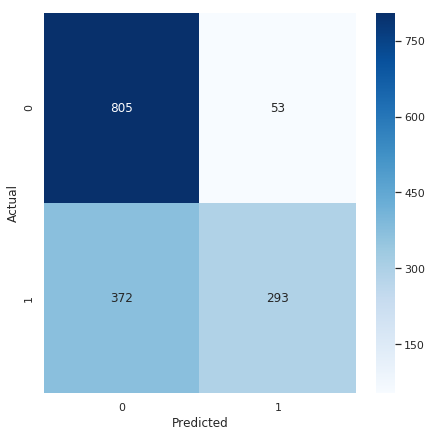

CPU times: user 561 ms, sys: 348 ms, total: 909 ms
Wall time: 376 ms


In [42]:
%%time
import pickle
model = LinearSVC()
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42,
#                                                                                 shuffle=True)

# svm = LinearSVC()
# model = CalibratedClassifierCV(svm) 
# clf.fit(X_train, y_train)
# y_proba = clf.predict_proba(X_test)

model.fit(features, labels)
y_pred = model.predict(X_test_tfidf)
conf_mat = confusion_matrix(y_test, y_pred)

# with open("pickled_algos/August1st_TFIDF_LinearSVC.pickle","wb") as f:
#     pickle.dump(model, f)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nClasification report:\n', classification_report(y_test, y_pred))


print("\nConfusion Matrix is very confusing")
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = "Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# test_pred_tfidf = model_BERT.predict(test_input)
# test_pred_tfidf_int = test_pred_tfidf.round().astype('int')
# submission['target'] = test_pred_BERT_int
# submission.to_csv("submission_bert_nodropout30.csv", index=False, header=True)

> ## 9. GloVe <a class="anchor" id="9"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties : 50D, 100D and 200 Dimentional. We will try 100D here.

In [43]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text_cleaned']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus   

In [44]:
corpus=create_corpus_new(df)

100%|██████████| 7613/7613 [00:03<00:00, 2280.22it/s]


In [45]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [46]:
MAX_LEN = 32
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [47]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 16966


In [48]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec           

100%|██████████| 16966/16966 [00:00<00:00, 245491.29it/s]


## Baseline Model with GloVe results

### Bidirectional LSTM

In [49]:
# Bidirectional LSTM

model=Sequential()
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)
model.add(embedding)
model.add(Bidirectional(LSTM(100,return_sequences=True,dropout=0.50, recurrent_dropout=0.5)))
model.add(TimeDistributed(Dense(100,activation='relu')))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=5e-5)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           1696700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 100)           20100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               320100    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,197,801
Trainable params: 501,101
Non-trainable params: 1,696,700
______________________________________

In [51]:
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]

In [52]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target_relabeled'].values,test_size=0.25)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (5709, 32)
Shape of Validation  (1904, 32)


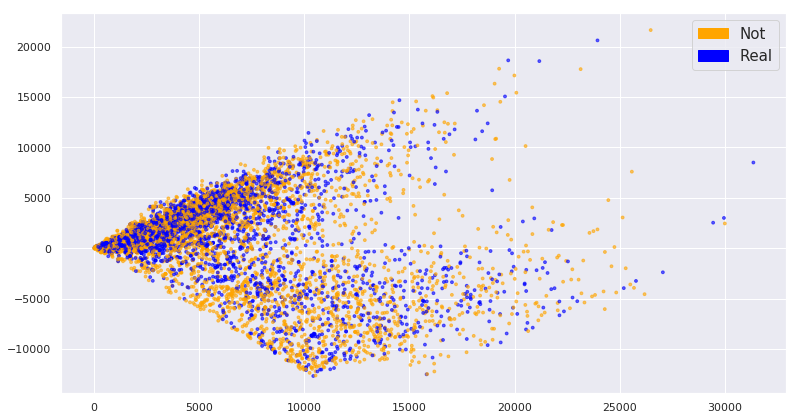

In [53]:
fig = plt.figure(figsize=(13, 7))          
plot_LSA(train,tweet['target'])
plt.show()

In [55]:
%%time
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model_biLSTM.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
# 10-20 epochs
history=model.fit(X_train,y_train,batch_size=16,epochs=15,validation_data=(X_test,y_test),verbose=1, callbacks=[checkpoint, es])

Train on 5709 samples, validate on 1904 samples
Epoch 1/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.5127 - accuracy: 0.7572 - val_loss: 0.4582 - val_accuracy: 0.8041
Epoch 2/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.4960 - accuracy: 0.7618 - val_loss: 0.4592 - val_accuracy: 0.8015
Epoch 3/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.4817 - accuracy: 0.7754 - val_loss: 0.4394 - val_accuracy: 0.8083
Epoch 4/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.4842 - accuracy: 0.7761 - val_loss: 0.4356 - val_accuracy: 0.8067
Epoch 5/15
5709/5709 [==============================] - 14s 3ms/step - loss: 0.4785 - accuracy: 0.7837 - val_loss: 0.4342 - val_accuracy: 0.8120
Epoch 6/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.4660 - accuracy: 0.7858 - val_loss: 0.4314 - val_accuracy: 0.8093
Epoch 7/15
5709/5709 [==============================] - 14s 2ms/step - loss: 0.471

In [56]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in y_pred])
print('  Classification Report:\n',classification_report(y_test,y_pred),'\n')

Accuracy: 80.882353
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.73      1102
           1       0.00      0.00      0.00       802

    accuracy                           0.58      1904
   macro avg       0.29      0.50      0.37      1904
weighted avg       0.33      0.58      0.42      1904
 



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# train_pred_bi_lstm = model.predict(train)
# train_pred_GloVe_int = train_pred_GloVe.round().astype('int')
# test_pred_bilstm = model.predict(test)
# test_pred_bilstm_int = test_pred_bilstm.round().astype('int')
# submission['target'] = test_pred_bilstm_int
# submission.to_csv("submission_glove.csv", index=False, header=True)
# submission.head(10)

In [ ]:
# train_pred_GloVe = model.predict(train)
# train_pred_GloVe_int = train_pred_GloVe.round().astype('int')
# test_pred_GloVe = model.predict(testa)
# test_pred_GloVe_int = test_pred_GloVe.round().astype('int')
# submission['target'] = test_pred_GloVe_int
# submission.to_csv("submission_glove.csv", index=False, header=True)
# submission.head(10)

In [ ]:
# pred = pd.DataFrame(train_pred_GloVe, columns=['preds'])
# pred.plot.hist()

> ## 11. Clustering on TFIDF embedding <a class="anchor" id="11"></a>

[Back to Table of Contents](#0.1)

### Hierarchical Clustering

In [57]:
%%time
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')

cluster.fit_predict(X_train)

CPU times: user 1.57 s, sys: 139 ms, total: 1.71 s
Wall time: 1.75 s


array([0, 0, 0, ..., 0, 0, 0])

In [58]:
# evaluate the model
print('Classification Report:\n',classification_report(y_train,cluster.labels_),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.83      0.67      3268
           1       0.36      0.12      0.18      2441

    accuracy                           0.53      5709
   macro avg       0.46      0.48      0.43      5709
weighted avg       0.47      0.53      0.46      5709
 



### Affinity Propagation:

In [59]:
from sklearn.cluster import AffinityPropagation

In [60]:
%%time
clustering = AffinityPropagation().fit_predict(X_train)

CPU times: user 56.9 s, sys: 1.72 s, total: 58.7 s
Wall time: 58.2 s


In [61]:
print(len(set(clustering)))

586


Prediction of 586 classes does not make any sense

In [ ]:
# print('Classification Report:\n',classification_report(y_train,clustering.labels_),'\n')

### DBScan

In [62]:
from sklearn.cluster import DBSCAN

In [122]:
clusteringDBS = DBSCAN(min_samples=17).fit_predict(X_train)

In [123]:
print(len(set(clusteringDBS)))

2


In [124]:
set(clusteringDBS)

{-1, 0}

In [128]:
y_pred1 = [0 if i == -1 else 1 for i in clusteringDBS]

print('Classification Report:\n',classification_report(y_train,y_pred1),'\n')

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73      3268
           1       1.00      0.01      0.01      2441

    accuracy                           0.58      5709
   macro avg       0.79      0.50      0.37      5709
weighted avg       0.76      0.58      0.42      5709
 



## 10. BERT using TFHub <a class="anchor" id="10"></a>

[Back to Table of Contents](#0.1)

https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub

In [ ]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow_hub as hub

import tokenization

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
learning_rate = 2e-6
valid = 0.2
epochs_num = 7
batch_size_num = 16
target_corrected = True
target_big_corrected = True
optimizer1 = Adam(lr=learning_rate)
optimizer2 = SGD(learning_rate=learning_rate, momentum=0.75)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(SGD(learning_rate=learning_rate, momentum=0.8), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Load BERT from the Tensorflow Hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
# Load CSV files containing training data
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [ ]:
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

def clean(df):
    df['text'] = df['text'].apply(lambda x : remove_URL(x))
    df['text'] = df['text'].apply(lambda x : remove_html(x))
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    df['text'] = df['text'].apply(lambda x : remove_punct(x))
    df['text'] = df['text'].apply(lambda x : convert_abbrev_in_text(x))
#     df['text'] = df['text'].apply(lambda x : clean_tweets(x))
#     df['text'] = df['text'].apply(lambda x : lemmatization(x))
    return df

# Thanks to https://www.kaggle.com/wrrosa/keras-bert-using-tfhub-modified-train-data - 
# author of this kernel read tweets in training data and figure out that some of them have errors:
if target_corrected:
    ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
    train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
    train[train['id'].isin(ids_with_target_error)]
    

if target_big_corrected:
    train.dropna(subset=["target"], inplace=True)
    train = clean(train)
    test = clean(test)

In [ ]:
# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

---

## DROPOUT

In [ ]:
# Model: Build, Train, Predict, Submit -- DROPOUT
Dropout_num = 0.25

model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

In [ ]:
%%time 
# DOROPOUT
checkpoint = ModelCheckpoint('model_dropout.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num,
    callbacks=[checkpoint, es],
    batch_size = batch_size_num
)

In [ ]:
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

submission['target'] = test_pred_BERT_int
submission.to_csv("submission_bert_dropout.csv", index=False, header=True)

---

## NO DROPOUT

In [ ]:
# Model: Build, Train, Predict, Submit -- NO DROPOUT
Dropout_num = 0
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

In [ ]:
%%time
# NO DROPOUT:
checkpoint = ModelCheckpoint('model_dropout.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num,
    callbacks=[checkpoint, es],
    batch_size = batch_size_num
)

In [ ]:
# train_pred_BERT = model_BERT.predict(train_input)
# train_pred_BERT_int = train_pred_BERT.round().astype('int')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')
submission['target'] = test_pred_BERT_int
submission.to_csv("submission_bert_nodropout.csv", index=False, header=True)

In [ ]:
"""
learning_rate = 2e-4
valid = 0.2
epochs_num = 15
batch_size_num = 16
target_corrected = True
target_big_corrected = False
optimizer = Adam(lr=learning_rate)
SGD = 0.8
score = 0.82004
"""

"""
NO DROPOUT
learning_rate = 2e-6
valid = 0.2
epochs_num = 7
batch_size_num = 16
target_corrected = True
target_big_corrected = False
optimizer = Adam(lr=learning_rate)
val score: 0.8418
real score: 0.82310
"""


"""
Dropout_num = 0.25
learning_rate = 2e-6
valid = 0.2
epochs_num = 7
batch_size_num = 16
target_corrected = True
target_big_corrected = False
optimizer = Adam(lr=learning_rate)
val: 0.8464
real: 0.82924
"""

"""
learning_rate = 2e-6
valid = 0.2
epochs_num = 7
batch_size_num = 16
target_corrected = False
target_big_corrected = False
optimizer = Adam(lr=learning_rate)
val:0.8365
real: 
"""

"""
learning_rate = 2e-6
valid = 0.2
epochs_num = 7
batch_size_num = 16
target_corrected = False
target_big_corrected = False
optimizer = Adam(lr=learning_rate)
Dropout_num = 0.25
val:0.8365
real: 
"""


[Go to Top](#0)